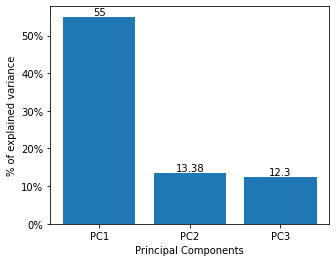

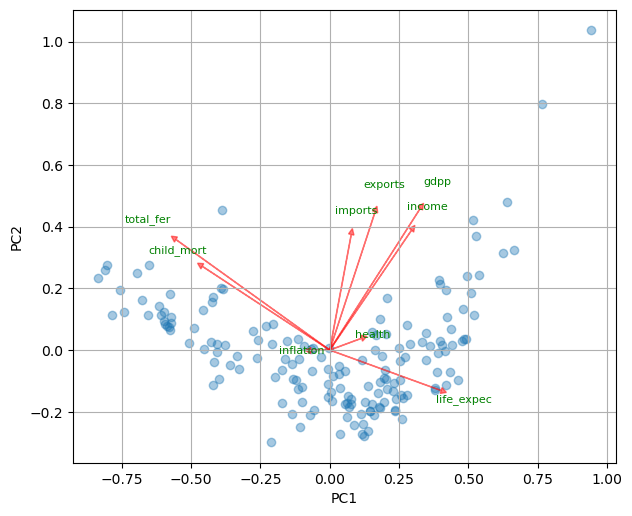

In [17]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts import *
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

raw_df = pd.read_csv('../data/country-data.csv')
countries, df_pca, explained_variance = pre_process_data(raw_df, 
                                                         scaler = 'minmax', 
                                                         pca = True,
                                                         biplot = True, 
                                                         plot_scree_plot = True, 
                                                         pca_components = 3,
                                                          plot_pc=("PC1", 'PC2'))

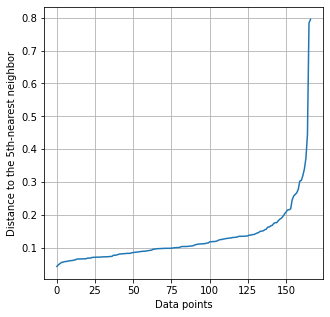

In [18]:
dbscan_epsilon(df_pca, min_samples = 5)

In [19]:
dbscan = DBSCAN(eps=0.14, min_samples=6)
dbscan.fit_predict(df_pca)
df_pca['cluster'] = dbscan.labels_

clustered_df, pivot = pivot_table(df_pca, raw_df)

s = cal_silhouette(clustered_df.drop("country", axis=1).query("cluster != -1"))
print(s)

scatter_plot_data(df_pca,#.query("cluster != -1"), 
                  ['PC1','PC2'], 
                  countries,
                  #countries.loc[df_pca.query("cluster != -1").index], 
                  three=False)
#create_map_plot(clustered_df)

-0.07154117882565178


In [20]:
dbscan = DBSCAN(eps=0.14, min_samples=6)
dbscan.fit_predict(df_pca)
df_pca['cluster'] = dbscan.labels_

clustered_df, pivot = pivot_table(df_pca, raw_df)

s = cal_silhouette(clustered_df.drop("country", axis=1).query("cluster != -1"))
print(s)

scatter_plot_data(df_pca,#.query("cluster != -1"), 
                  ['PC1','PC3'], 
                  countries,
                  #countries.loc[df_pca.query("cluster != -1").index], 
                  three=False)
#create_map_plot(clustered_df)

-0.07154117882565178


In [21]:
dbscan = DBSCAN(eps=0.14, min_samples=6)
dbscan.fit_predict(df_pca)
df_pca['cluster'] = dbscan.labels_

s = cal_silhouette(clustered_df.drop("country", axis=1).query("cluster != -1"))
print("silhouette score: ", s)
clustered_df, pivot = pivot_table(df_pca, raw_df)

scatter_plot_data(df_pca, ['PC1', 'PC3'], countries, three=False)
#create_map_plot(clustered_df)

silhouette score:  -0.07154117882565178


In [27]:
df_pca['country'] = countries
df_pca[df_pca.cluster == 2].country

31     Central African Republic
32                         Chad
37             Congo, Dem. Rep.
66                        Haiti
97                         Mali
112                       Niger
Name: country, dtype: object

In [31]:
# print(round(pivot, 2).to_latex())
pivot

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
-1,43.854167,65.463333,7.887917,66.054167,35998.500000,8.875875,71.508333,3.309583,29189.166667
0,36.542500,37.814825,6.166917,44.907216,11242.400000,8.518242,69.815833,2.898833,6258.158333
1,4.147059,35.664706,10.318235,34.588235,37794.117647,1.340353,80.988235,1.724118,41770.588235
2,147.166667,25.000000,5.578333,44.750000,1268.500000,6.928333,51.983333,5.951667,565.833333


# DBSCAN Clustering algorithm

DBSCAN works as following:
- For each instance in the data, the algorithm counts how many instances are located within a small distance $\epsilon$ (epsilon) from it. So, in 3-dimensional space, that would be the radius a sphere.
- If an instance has at least `min_samples` instances in its $\epsilon$-neighborhood (including itself), then it is considered a *core instance*. In other words; core instances are those that are located in dense regions.
- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.
  

# Determine the optimal value for $\epsilon$

## Nereast neighbours approach

Source:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

To determine a a good value for $\epsilon$, we find a suitable value for $\epsilon$ by calculating the distance to the nearest $n$ points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced and select that as $\epsilon$.

we can calculate the distance from each point to its closest neighbour using the `NearestNeighbors`. The point itself is included in `n_neighbors`. The `kneighbors` method returns two arrays, one which contains the distance to the closest `n_neighbors` points and the other which contains the index for each of those points.

Source: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan?rq=1

eps hyperparameter

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: Sander et al. 1998 and Schubert et al. 2017 (both papers from the original DBSCAN authors).

Here's a condensed version of their approach: If you have N-dimensional data to begin, then choose n_neighbors in sklearn.neighbors.NearestNeighbors to be equal to 2xN - 1, and find out distances of the K-nearest neighbors (K being 2xN - 1) for each point in your dataset. Sort these distances out and plot them to find the "elbow" which separates noisy points (with high K-nearest neighbor distance) from points (with relatively low K-nearest neighbor distance) which will most likely fall into a cluster. The distance at which this "elbow" occurs is your point of optimal eps.

Here's some python code to illustrate how to do this: